# Constraint Satisfaction Problems



## Programming assignment: Sudoku

In this exercise, we want to use a fast CSP solver to compute solutions of so-called Sudoku puzzles.

A Sudoku consists of a 9x9 grid, each cell of which is to be assigned precisely one of the digits 1-9, subject to the following constraints:
- in every row of the grid, no two cells may contain the same digits.
- in every column of the grid, no two cells may contain the same digits.
- <del>in the two main diagonals, no two cells may contain the same digits.</del>
- in the non-overlapping 9 3x3 sub-grids partioning the full grid, no two cells may contain the same digits.

Initially, a partial assignment of grid cells is given.

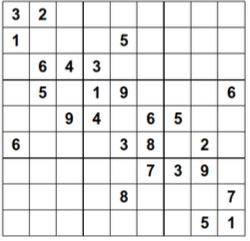

### 1. Present the given Sudoku puzzle with a 9x9 2D array

In [1]:
puzzle = [
    [3, 2, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 6, 4, 3, 0, 0, 0, 0, 0],
    [0, 5, 0, 1, 9, 0, 0, 0, 6],
    [0, 0, 9, 4, 0, 6, 5, 0, 0],
    [6, 0, 0, 0, 3, 8, 0, 2, 0],
    [0, 0, 0, 0, 0, 7, 3, 9, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 0, 5, 1]
]

### 2. A general CSP solver Class

Click the code cell below to see the implementation details.

In [2]:
from copy import deepcopy

class CSP:
    def __init__(self, variables, domains, neighbors, constraint, debug_fun=None):
        # Initialize the CSP problem with variables, domains, neighbors, and constraints
        self.variables = variables         # List of variables (e.g., Sudoku cells)
        self.domains = domains             # Dict: Maps each variable to its possible values
        self.neighbors = neighbors         # Dict: Maps each variable to its constrained neighbors
        self.constraint = constraint       # Function: Checks if two assignments satisfy constraints
        self.debug_fun = debug_fun         # Function: Debug function for visualization

    def assign(self, var, val, assignment):
        """Assign a value to a variable and update the assignment dictionary."""
        assignment[var] = val

    def unassign(self, var, assignment):
        """Remove a variable's assignment (used during backtracking)."""
        if var in assignment:
            del assignment[var]

    def nconflicts(self, var, val, assignment):
        """Calculate the number of conflicts a proposed assignment (var=val) has with current assignments."""
        count = 0
        for nbr in self.neighbors[var]:
            # Check if neighbor is assigned and if the constraint is violated
            if nbr in assignment and not self.constraint(var, val, nbr, assignment[nbr]):
                count += 1
        return count

    def ac3(self, queue=None):
        """Enforce arc consistency using the AC-3 algorithm. Returns False if inconsistency found."""
        # Initialize queue with all arcs if not provided
        if queue is None:
            queue = [(xi, xj) for xi in self.variables for xj in self.neighbors[xi]]
        print(f"Perform forward checking...")
        while queue:
            xi, xj = queue.pop(0)
            # Revise Xi's domain based on Xj's constraints
            if self.revise(xi, xj):
                if not self.domains[xi]:
                    if self.debug_fun is not None:
                        print(f"Domain of grid {xi} will be empty!")
                        print("AC-3 forward checking failed! Undo the modifications above.")
                        sleep(3)
                    return False  # Domain empty: no solution
                # Add arcs (Xk, Xi) to queue to recheck neighbors of Xi
                for xk in self.neighbors[xi]:
                    if xk != xj:
                        queue.append((xk, xi))
        sleep(0.5)
        return True

    def revise(self, xi, xj):
        """Check and remove values from Xi's domain that conflict with Xj's domain."""
        revised = False
        # Iterate over a copy to safely remove values
        for x in self.domains[xi][:]:
            # If no value in Xj's domain satisfies the constraint for x, remove x
            if all(not self.constraint(xi, x, xj, y) for y in self.domains[xj]):
                if self.debug_fun is not None:
                    print(f"Remove {x} from domain {xi}: {self.domains[xi]}")
                self.domains[xi].remove(x)
                revised = True
        return revised

    def backtracking_search(self):
        """Entry point for the backtracking search algorithm."""
        # Start with an empty assignment set
        assignment = {}
        return self.backtrack(assignment)

    def backtrack(self, assignment):
        """Recursive backtracking search with inference (forward checking and AC-3)."""
        # Base case: All variables are assigned, return the solution
        if len(assignment) == len(self.variables):
            return assignment
        # Select variable with Minimum Remaining Values (MRV) heuristic
        unassigned = [v for v in self.variables if v not in assignment]
        var = min(unassigned, key=lambda v: len(self.domains[v]))
        # Try each value in the variable's domain
        for val in list(self.domains[var]):
            if self.debug_fun is not None:
                self.debug_fun(var, val, f"Trying {val} on grid {var}, domains: {self.domains[var]}")
            
            if self.nconflicts(var, val, assignment) == 0:
                # Assign value and enforce forward checking
                self.assign(var, val, assignment)
                saved_domains = deepcopy(self.domains)  # Backup domains for backtracking
                # Prune domains using AC-3, starting with arcs (neighbor, var)
                self.domains[var] = [val]  # Enforce unary constraint (var=val)
                
                if self.ac3([(nbr, var) for nbr in self.neighbors[var]]):
                    # Recurse with the updated assignment and domains
                    result = self.backtrack(assignment)
                    if result:
                        return result

                # Restore domains and unassign if path failed
                self.unassign(var, assignment)
                self.domains = saved_domains
        return None  # No solution found in this branch

## Task: Implement a function that initializes a Sudoku CSP solver

Properly setup the `variables`, `domains`, `neighbors`, and `constraint function`:

- `variables`: 81 (row, column) cells in the grid
- `domains`: each cell’s candidate digits
- `neighbors`: cells in the same row, column, or 3x3 block,
- `constraint`: A constraint function that test any neighbors must have different values

In [3]:
def sudoku_csp(grid):
    """Create a CSP for a Sudoku puzzle from a 9x9 grid (0 represents empty)."""

    variables = []

    domains = {}
    
    neighbors = {}
    
    def constraint():
        return False
        
    return CSP(variables, domains, neighbors, constraint)

## Solution

In [4]:
def sudoku_csp(grid, debug_fun=None):
    """Create a CSP for a Sudoku puzzle from a 9x9 grid (0 represents empty)."""
    # Variables are all (row, column) cells in the grid
    variables = [(r, c) for r in range(9) for c in range(9)]
    
    domains = {}
    for r in range(9):
        for c in range(9):
            if grid[r][c] != 0:
                domains[(r, c)] = [grid[r][c]]  # Pre-filled cells have fixed values
            else:
                domains[(r, c)] = list(range(1, 10))  # Empty cells can be 1-9
    # Build neighbors: cells in the same row, column, or 3x3 block
    neighbors = {var: set() for var in variables}
    for r, c in variables:
        # Add same row and column neighbors (excluding self)
        for k in range(9):
            if k != c:
                neighbors[(r, c)].add((r, k))
            if k != r:
                neighbors[(r, c)].add((k, c))
        # Add 3x3 block neighbors
        br, bc = 3 * (r // 3), 3 * (c // 3)  # Block top-left corner
        for dr in range(3):
            for dc in range(3):
                cell = (br + dr, bc + dc)
                if cell != (r, c):
                    neighbors[(r, c)].add(cell)
    # Constraint function: Neighbors must have different values
    def constraint(A, a, B, b):
        return a != b

    return CSP(variables, domains, neighbors, constraint, debug_fun)

### Verify your Sudoku CSP solver

In [5]:
from time import sleep
from IPython.display import clear_output, display
import pandas as pd

sudoku_viz = pd.DataFrame(puzzle)

# A debug function for displaying the search process
def slow_print(current_cell, value, message, wait=0):
    clear_output(wait=True)
    sudoku_viz.at[current_cell[0], current_cell[1]] = value
    def highlight_cell(x):
        df_style = pd.DataFrame('', index=x.index, columns=x.columns)
        df_style.loc[current_cell[0], current_cell[1]] = 'background-color: yellow'
        return df_style
    display(sudoku_viz.style.apply(highlight_cell, axis=None))
    display(message)
    sleep(wait)

# Start Backtracking search
csp = sudoku_csp(puzzle, slow_print)

# Start Backtracking search without displaying process
# csp = sudoku_csp(puzzle)


# csp = sudoku_csp(puzzle)
solution = csp.backtracking_search()

if solution:
    # Convert the assignment to a 2D grid and print
    solved_grid = [[solution[(r,c)] for c in range(9)] for r in range(9)]
    
    print("Solved puzzle:\n")
    for row in solved_grid:
        print(row)
else:
    print("No solution exists for the given puzzle.")

,0,1,2,3,4,5,6,7,8
0,3,2,5,8,6,1,7,4,9
1,1,9,8,7,5,4,6,3,2
2,7,6,4,3,2,9,1,8,5
3,4,5,3,1,9,2,8,7,6
4,2,8,9,4,7,6,5,1,3
5,6,1,7,5,3,8,9,2,4
6,5,4,2,6,1,7,3,9,8
7,9,3,1,2,8,5,4,6,7
8,8,7,6,9,4,3,2,5,1


'Trying 2 on grid (8, 6), domains: [2]'

Perform forward checking...
Solved puzzle:

[3, 2, 5, 8, 6, 1, 7, 4, 9]
[1, 9, 8, 7, 5, 4, 6, 3, 2]
[7, 6, 4, 3, 2, 9, 1, 8, 5]
[4, 5, 3, 1, 9, 2, 8, 7, 6]
[2, 8, 9, 4, 7, 6, 5, 1, 3]
[6, 1, 7, 5, 3, 8, 9, 2, 4]
[5, 4, 2, 6, 1, 7, 3, 9, 8]
[9, 3, 1, 2, 8, 5, 4, 6, 7]
[8, 7, 6, 9, 4, 3, 2, 5, 1]
